## Artificial Neural Network

Let’s summarize the MLP learning procedure in three simple steps:
1. Starting at the input layer, we forward propagate the patterns of the training data through the
network to generate an output.
2. Based on the network’s output, we calculate the loss that we want to minimize using a loss
function that we will describe later.
3. We backpropagate the loss, find its derivative with respect to each weight and bias unit in the
network, and update the model.

Finally, after we repeat these three steps for multiple epochs and learn the weight and bias parame-
ters of the MLP, we use forward propagation to calculate the network output and apply a threshold
function to obtain the predictions.

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

In [3]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [4]:
# Normalizing the pixel values in MNIST to the range -1 to 1 (originally 0 to 255)
X = ((X / 255.) - .5) * 2

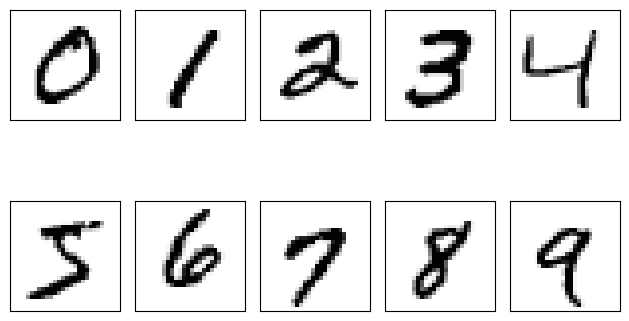

In [6]:
# plotting a sample of the digits
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28) 
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

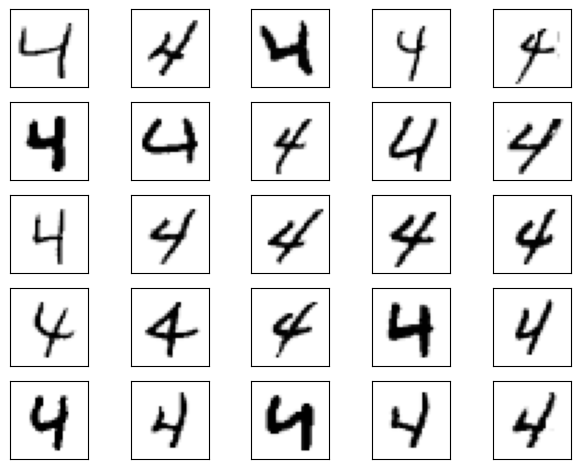

In [7]:
# plotting samples of same digit
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y==4][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[i].set_xticks([])
ax[i].set_yticks([])
plt.tight_layout()
plt.show()

In [9]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=10000, random_state=123, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=5000, random_state=123, stratify=y_temp)

## Multi-Layer Perceptron from scratch

In [10]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

In [11]:
def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    
    return ary

In [15]:
class NeuralNetMLP:

    '''The __init__ constructor instantiates the weight matrices and bias vectors for the hidden and the output layer.'''
    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        self.num_classes = num_classes

        #hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        #output
        self.weight_out = rng.normal(loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    '''The forward method takes in one or more training examples and returns the predictions. In fact, it
    returns both the activation values from the hidden layer and the output layer, a_h and a_out. While
    a_out represents the class-membership probabilities that we can convert to class labels, which we
    care about, we also need the activation values from the hidden layer, a_h, to optimize the model pa-
    rameters; that is, the weight and bias units of the hidden and output layers.'''

    def forward(self, x):
        # hidden layer
        # input dim : [n_hidden, n_features]
        #         dot [n_features, n_examples].T
        # output dim : [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # output layer
        # input dim : [n_classes, n_hidden]
        #         dot [n_hidden, n_examples].T
        # output dim : [n_examples, n_classes]

        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out
    
    '''The backward method implements the so-called backpropagation algorithm, which calculates the gradients 
    of the loss with respect to the weight and bias parameters. Similar to Adaline, these gradients
    are then used to update these parameters via gradient descent. Note that multilayer NNs are more
    complex than their single-layer siblings, and we will go over the mathematical concepts of how to
    compute the gradients in a later section after discussing the code. For now, just consider the backward
    method as a way for computing gradients that are used for the gradient descent updates. For simplic-
    ity, the loss function this derivation is based on is the same MSE loss that we used in Adaline.'''
    
    def backward(self, x, a_h, a_out, y):
        #########################
        ### Output layer weights
        #########################

        # one hot encode
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # Sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples]
        #        dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #########################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dHiddenWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # Sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, d_loss__d_w_h, d_loss__d_b_h)



In [16]:
model = NeuralNetMLP(num_features=28*28, num_classes=10, num_hidden = 50)

![NN-architecture](/Users/subashpandey/Desktop/ML-DL-From-Scratch/images/NN-architecture.png "NN-architecture")

## Training the Neural Network

In [17]:
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)
    for start_idx in range(0, indices.shape[0] - minibatch_size + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        yield X[batch_idx], y[batch_idx]

In [18]:
# Testing the mini batch generator
for i in range(num_epochs):
    # iterate over mini batches
    minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
    for X_train_mini, y_train_mini in minibatch_gen:
        break
    break
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [20]:
# evaluation metrics
def mse_loss(targets, probas, num_labels = 10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)

def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)

In [21]:
_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)
print(f"Initial Validation MSE: {mse:.2f}")

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)
print(f"Initial Validation Accuracy: {acc*100:.2f}%")

Initial Validation MSE: 0.27
Initial Validation Accuracy: 9.36%


In [23]:
# Computing MSE and accuracy incrementally by iterating over the dataset one mini-batch at a time
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)
    for i, (features, targets) in enumerate(minibatch_gen):
        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas) ** 2)
        correct_pred += (predicted_labels == targets).sum()
        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [25]:
# Testing the function
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.2f}')
print(f'Initial validation accuracy: {acc*100:.2f}%')

Initial valid MSE: 0.28
Initial validation accuracy: 9.36%


## Training

In [26]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):
        # iterate over minibatches
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size)
        for X_train_mini, y_train_mini in minibatch_gen:
            ### Compute outputs ###
            a_h, a_out = model.forward(X_train_mini)

            ### Compute gradients ###
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini, a_h, a_out, y_train_mini)


            ### Update weights ###
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        ### Epoch loggin ###
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc * 100, valid_acc*100

        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')
        
    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [27]:
np.random.seed(123)
epoch_loss, epoch_train_acc, epoch_valid_acc = train(model, X_train, y_train, X_valid, y_valid, num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.05 | Train Acc: 76.15% | Valid Acc: 75.98%
Epoch: 002/050 | Train MSE: 0.03 | Train Acc: 85.45% | Valid Acc: 85.04%
Epoch: 003/050 | Train MSE: 0.02 | Train Acc: 87.82% | Valid Acc: 87.60%
Epoch: 004/050 | Train MSE: 0.02 | Train Acc: 89.36% | Valid Acc: 89.28%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 90.21% | Valid Acc: 90.04%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 90.67% | Valid Acc: 90.54%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 91.12% | Valid Acc: 90.82%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 91.43% | Valid Acc: 91.26%
Epoch: 009/050 | Train MSE: 0.01 | Train Acc: 91.84% | Valid Acc: 91.50%
Epoch: 010/050 | Train MSE: 0.01 | Train Acc: 92.04% | Valid Acc: 91.84%
Epoch: 011/050 | Train MSE: 0.01 | Train Acc: 92.30% | Valid Acc: 92.08%
Epoch: 012/050 | Train MSE: 0.01 | Train Acc: 92.51% | Valid Acc: 92.24%
Epoch: 013/050 | Train MSE: 0.01 | Train Acc: 92.65% | Valid Acc: 92.30%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 92.80

## Evaluating the Neural Network Performance

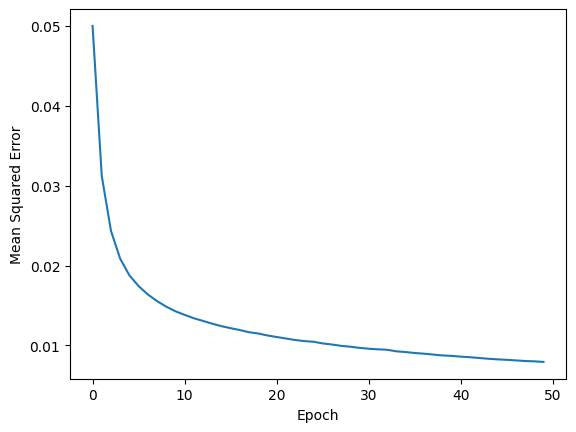

In [28]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean Squared Error')
plt.xlabel('Epoch')
plt.show()

As we can see, the loss decreased substantially during the first 10 epochs and seems to slowly converge
in the last 10 epochs. However, the small slope between epoch 40 and epoch 50 indicates that the loss
would further decrease with training over additional epochs.

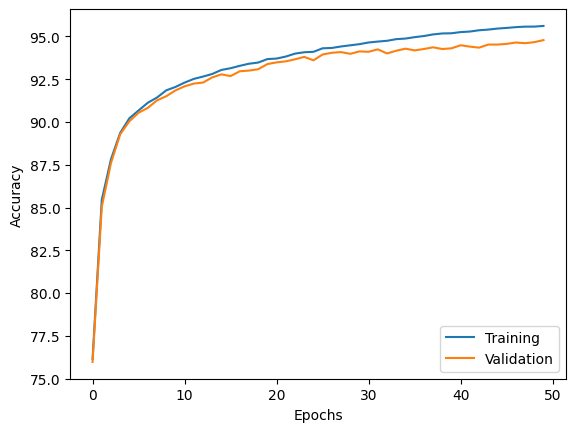

In [29]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc, label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc, label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

The plot reveals that the gap between training and validation accuracy increases as we train for more
epochs. At approximately the 25th epoch, the training and validation accuracy values are almost equal,
and then, the network starts to slightly overfit the training data.

In [30]:
# Prediction accuracy
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 94.54%


We can see that the test accuracy is very close to the validation set accuracy corresponding to the last
epoch (94.74%), which we reported during the training in the last subsection. Moreover, the respec-
tive training accuracy is only minimally higher at 95.59%, reaffirming that our model only slightly
overfits the training data.

## What does our MLP struggle at?

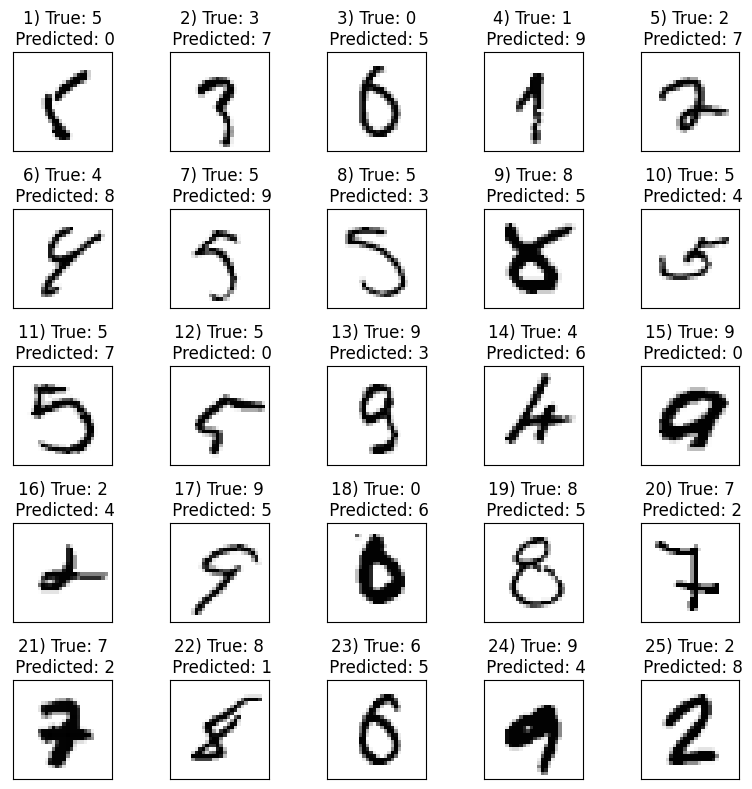

In [31]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]
_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)
misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28,28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

The network finds 7s challenging when they include a
horizontal line as in examples 19 and 20. Looking back at an earlier figure in this chapter where we
plotted different training examples of the number 7, we can hypothesize that the handwritten digit 7
with a horizontal line is underrepresented in our dataset and is often misclassified.